# Image Processing CookBook
## Chapter 8
### Author - Sandipan Dey

### Object (Person) Detection with HOG/SVM

51


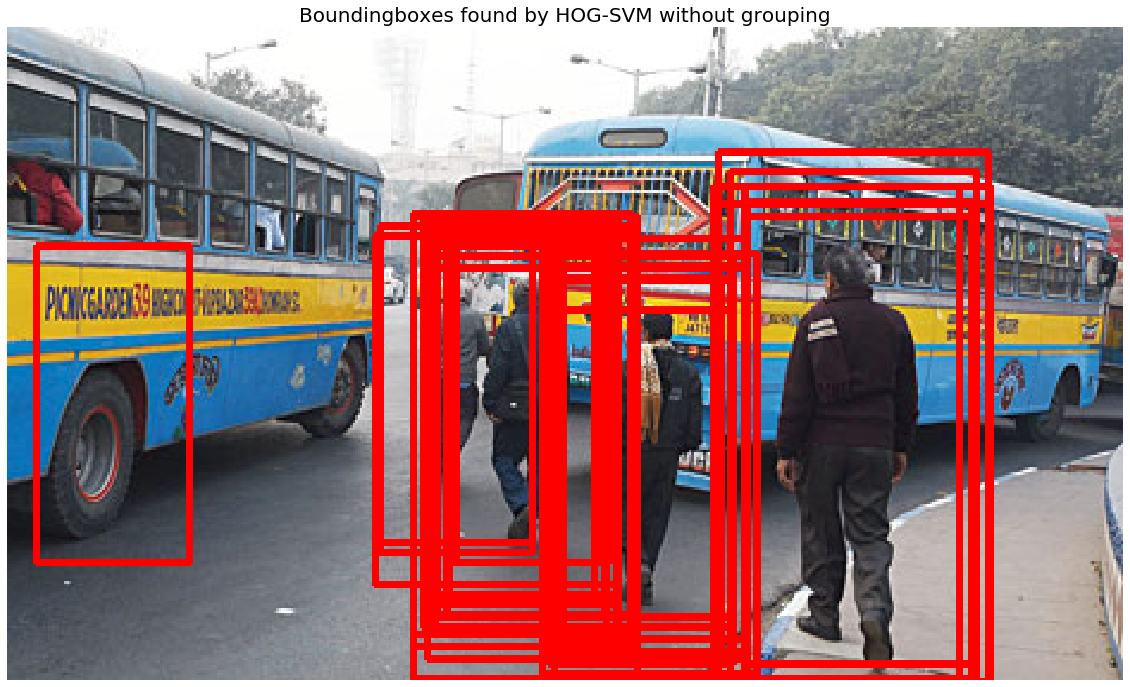

51
4


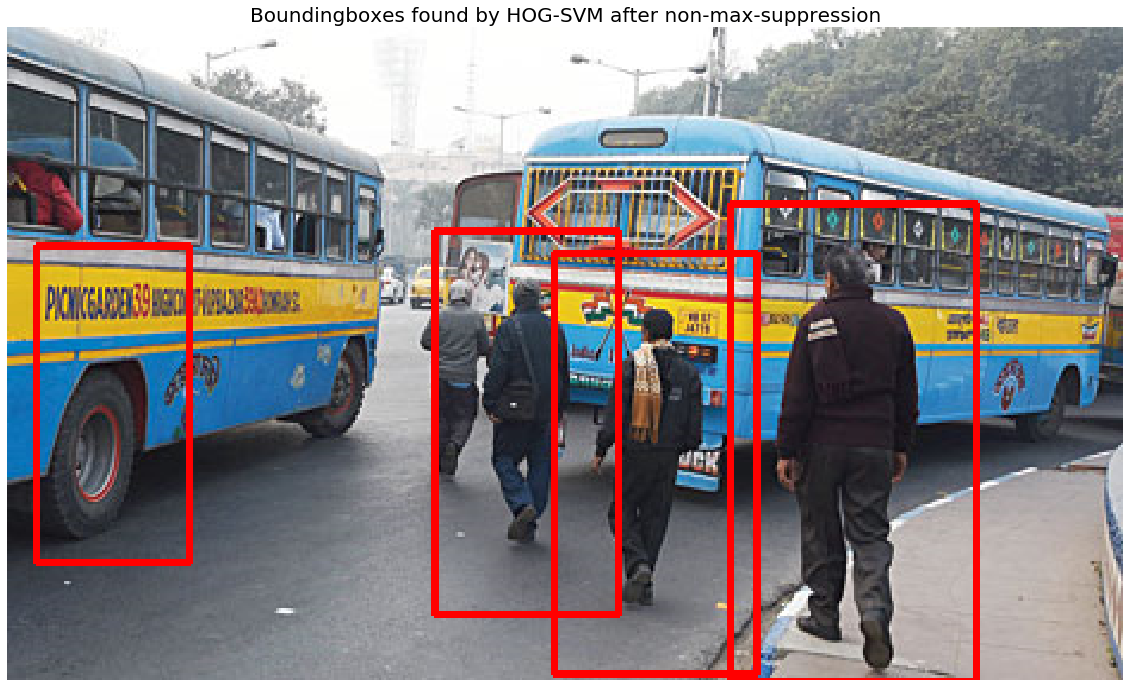

3


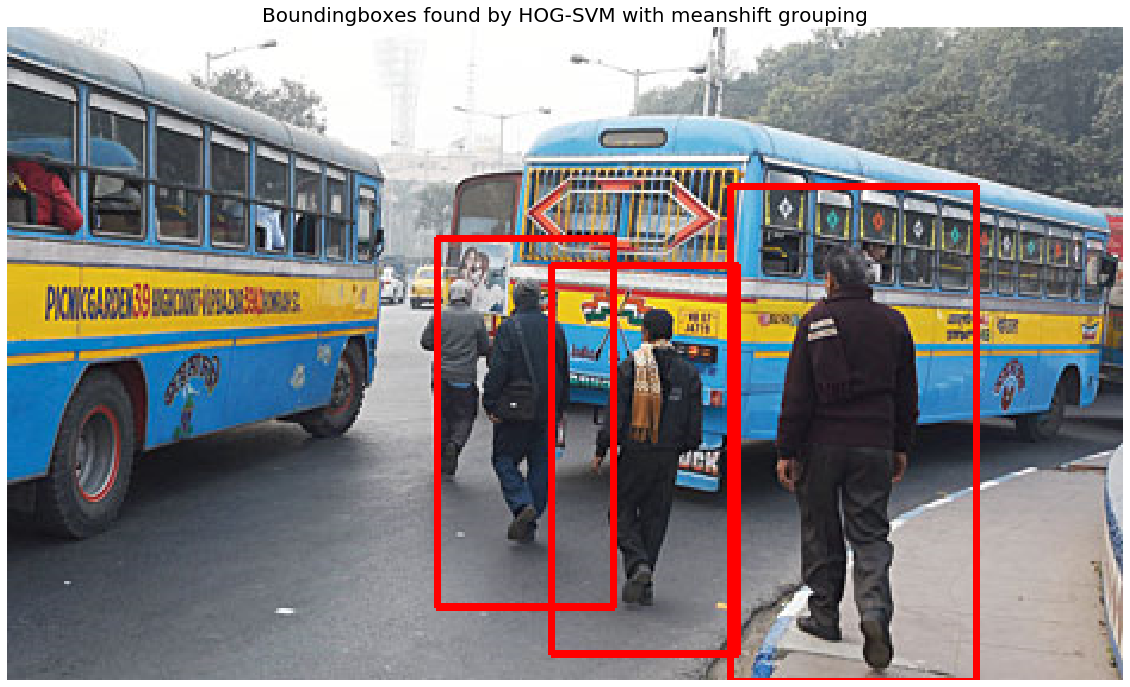

In [10]:
import numpy as np
import cv2
import matplotlib.pylab as plt

img = cv2.imread("images/walk.png")
# create HOG descriptor using default people (pedestrian) detector
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
# run detection, using a spatial stride of 4 pixels (horizontal and vertical), a scale stride of 1.02, and zero grouping of rectangles (to
# demonstrate that HOG will detect at potentially multiple places in the scale pyramid)
(foundBoundingBoxes, weights) = hog.detectMultiScale(img, winStride=(4, 4), padding=(8, 8), scale=1.1, finalThreshold=0)
print(len(foundBoundingBoxes)) # number of boundingboxes
# 314
# copy the original image to draw bounding boxes on it for now, as we'll use it again later
imgWithRawBboxes = img.copy()
for (hx, hy, hw, hh) in foundBoundingBoxes:
    cv2.rectangle(imgWithRawBboxes, (hx, hy), (hx + hw, hy + hh), (0, 0, 255), 2)
plt.figure(figsize=(20, 12))
imgWithRawBboxes = cv2.cvtColor(imgWithRawBboxes, cv2.COLOR_BGR2RGB)
plt.imshow(imgWithRawBboxes, aspect='auto'), plt.axis('off')
plt.title('Boundingboxes found by HOG-SVM without grouping', size=20)
plt.show()

#https://gist.github.com/CMCDragonkai/1be3402e261d3c239a307a3346360506
def non_max_suppression(boxes, scores, threshold):	
    assert boxes.shape[0] == scores.shape[0]
    # bottom-left origin
    ys1 = boxes[:, 0]
    xs1 = boxes[:, 1]
    # top-right target
    ys2 = boxes[:, 2]
    xs2 = boxes[:, 3]
    # box coordinate ranges are inclusive-inclusive
    areas = (ys2 - ys1) * (xs2 - xs1)
    scores_indexes = scores.argsort().tolist()
    boxes_keep_index = []
    while len(scores_indexes):
        index = scores_indexes.pop()
        boxes_keep_index.append(index)
        if not len(scores_indexes):
            break
        ious = compute_iou(boxes[index], boxes[scores_indexes], areas[index],
                           areas[scores_indexes])
        filtered_indexes = set((ious > threshold).nonzero()[0])
        # if there are no more scores_index
        # then we should pop it
        scores_indexes = [
            v for (i, v) in enumerate(scores_indexes)
            if i not in filtered_indexes
        ]
    return np.array(boxes_keep_index)


def compute_iou(box, boxes, box_area, boxes_area):
    # this is the iou of the box against all other boxes
    assert boxes.shape[0] == boxes_area.shape[0]
    # get all the origin-ys
    # push up all the lower origin-xs, while keeping the higher origin-xs
    ys1 = np.maximum(box[0], boxes[:, 0])
    # get all the origin-xs
    # push right all the lower origin-xs, while keeping higher origin-xs
    xs1 = np.maximum(box[1], boxes[:, 1])
    # get all the target-ys
    # pull down all the higher target-ys, while keeping lower origin-ys
    ys2 = np.minimum(box[2], boxes[:, 2])
    # get all the target-xs
    # pull left all the higher target-xs, while keeping lower target-xs
    xs2 = np.minimum(box[3], boxes[:, 3])
    # each intersection area is calculated by the  pulled target-x minus the pushed origin-x
    # multiplying pulled target-y minus the pushed origin-y 
    # we ignore areas where the intersection side would be negative
    # this is done by using maxing the side length by 0
    intersections = np.maximum(ys2 - ys1, 0) * np.maximum(xs2 - xs1, 0)
    # each union is then the box area added to each other box area minusing their intersection calculated above
    unions = box_area + boxes_area - intersections
    # element wise division
    # if the intersection is 0, then their ratio is 0
    ious = intersections / unions
    return ious

(foundBoundingBoxes, weights) = hog.detectMultiScale(img, winStride=(4, 4), padding=(8, 8), scale=1.1, finalThreshold=0)
print(len(foundBoundingBoxes)) # number of boundingboxes
# 70
foundBoundingBoxes[:,2] = foundBoundingBoxes[:,0] + foundBoundingBoxes[:,2]
foundBoundingBoxes[:,3] = foundBoundingBoxes[:,1] + foundBoundingBoxes[:,3]
boxIndices = non_max_suppression(foundBoundingBoxes, weights.ravel(), threshold=0.2)
foundBoundingBoxes = foundBoundingBoxes[boxIndices,:]
foundBoundingBoxes[:,2] = foundBoundingBoxes[:,2] - foundBoundingBoxes[:,0]
foundBoundingBoxes[:,3] = foundBoundingBoxes[:,3] - foundBoundingBoxes[:,1]
print(len(foundBoundingBoxes)) # number of boundingboxes
# 4
# copy the original image to draw bounding boxes on it for now, as we'll use it again later
imgWithRawBboxes = img.copy()
for (hx, hy, hw, hh) in foundBoundingBoxes:
    cv2.rectangle(imgWithRawBboxes, (hx, hy), (hx + hw, hy + hh), (0, 0, 255), 2)
plt.figure(figsize=(20, 12))
imgWithRawBboxes = cv2.cvtColor(imgWithRawBboxes, cv2.COLOR_BGR2RGB)
plt.imshow(imgWithRawBboxes, aspect='auto'), plt.axis('off')
plt.title('Boundingboxes found by HOG-SVM after non-max-suppression', size=20)
plt.show()

# with meanshiftgrouping to get rid of multiple detections of the same object
(foundBoundingBoxes, weights) = hog.detectMultiScale(img, winStride=(4, 4), padding=(8, 8), scale=1.01, useMeanshiftGrouping=True)
print(len(foundBoundingBoxes)) # number of boundingboxes
# 3
# copy the original image to draw bounding boxes on it for now, as we'll use it again later
imgWithRawBboxes = img.copy()
for (hx, hy, hw, hh) in foundBoundingBoxes:
    cv2.rectangle(imgWithRawBboxes, (hx, hy), (hx + hw, hy + hh), (0, 0, 255), 2)
plt.figure(figsize=(20, 12))
imgWithRawBboxes = cv2.cvtColor(imgWithRawBboxes, cv2.COLOR_BGR2RGB)
plt.imshow(imgWithRawBboxes, aspect='auto'), plt.axis('off')
plt.title('Boundingboxes found by HOG-SVM with meanshift grouping', size=20)
plt.show()

### Object Detection with Yolo V3 (OpenCV-python)

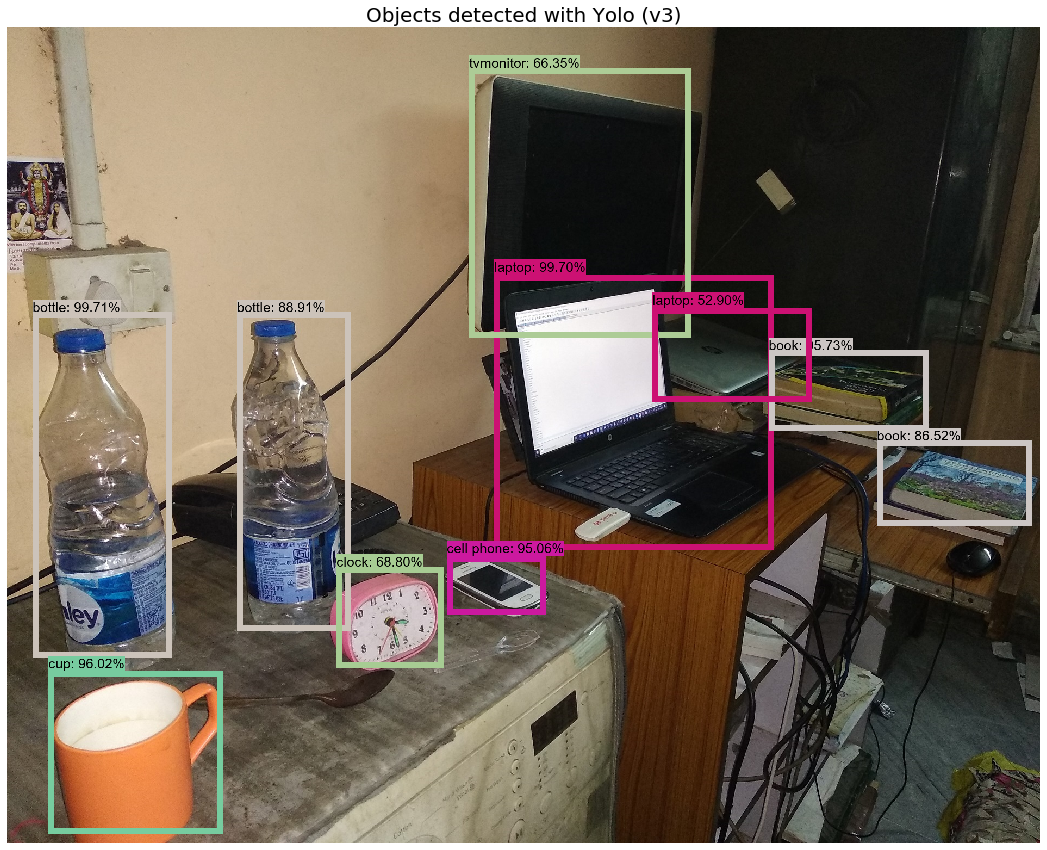

In [23]:
# https://pjreddie.com/darknet/yolo/
import cv2
import numpy as np
import matplotlib.pylab as plt
from PIL import Image, ImageDraw, ImageFont
import colorsys
from random import shuffle

# Initialize the parameters
conf_threshold = 0.5  #Confidence threshold
nms_threshold = 0.4   #Non-maximum suppression threshold
width = 416       #Width of network's input image
height = 416      #Height of network's input image

# Load names of classes
classesFile = "models/yolov3/coco_classes.txt";
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

# Give the configuration and weight files for the model and load the network using them.
modelConfiguration = "models/yolov3/yolov3.cfg";
modelWeights = "models/yolov3/yolov3.weights";

net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# Get the names of the output layers
def get_output_layers(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# Draw the predicted bounding box
def draw_boxes(img, classId, conf, left, top, right, bottom):
    # Draw a bounding box.
    label = "{}: {:.2f}%".format(classes[classId], conf * 100)
    color = tuple([int(255*x) for x in colors[classId]])
    top = top - 15 if top - 15 > 15 else top + 15
    pil_im = Image.fromarray(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)) 
    thickness = (img.shape[0] + img.shape[1]) // 300
    font = ImageFont.truetype("arial.ttf", 25) 
    draw = ImageDraw.Draw(pil_im)  
    label_size = draw.textsize(label, font)
    if top - label_size[1] >= 0:
        text_origin = np.array([left, top - label_size[1]])
    else:
        text_origin = np.array([left, top + 1])
    for i in range(thickness):
        draw.rectangle([left + i, top + i, right - i, bottom - i], outline=color)
    draw.rectangle([tuple(text_origin), tuple(text_origin +  label_size)], fill=color)
    draw.text(text_origin, label, fill=(0, 0, 0), font=font)
    del draw
    img = cv2.cvtColor(np.array(pil_im), cv2.COLOR_RGB2BGR)  
    
    return img


# Remove the bounding boxes with low confidence using non-maxima suppression
def post_process(img, outs):
    imgHeight = img.shape[0]
    imgWidth = img.shape[1]

    classIds = []
    confidences = []
    boxes = []
    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if confidence > conf_threshold:
                center_x = int(detection[0] * imgWidth)
                center_y = int(detection[1] * imgHeight)
                width = int(detection[2] * imgWidth)
                height = int(detection[3] * imgHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        img = draw_boxes(img, classIds[i], confidences[i], left, top, left + width, top + height)
        
    return img

HSV_tuples = [(x/len(classes), x/len(classes), 0.8) for x in range(len(classes))]
shuffle(HSV_tuples)
colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))

img = cv2.imread('images/mytable.png')

orig = np.copy(img)
# Create a 4D blob from a img.
blob = cv2.dnn.blobFromImage(img, 1/255, (width, height), [0,0,0], 1, crop=False)

# Sets the input to the network
net.setInput(blob)

# Runs the forward pass to get output of the output layers
outs = net.forward(get_output_layers(net))

# Remove the bounding boxes with low confidence
img = post_process(img, outs)

# Put efficiency information. The function getPerfProfile returns the overall time for inference(t) and the timings for each of the layers(in layersTimes)
t, _ = net.getPerfProfile()
#label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
#cv2.putText(img, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

fig = plt.figure(figsize=(20,15))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Objects detected with Yolo (v3)', size=20)
plt.show()

### Object Detection with Faster-RCNN (TensorFlow ResNet)

In [28]:
# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md
%matplotlib inline
import numpy as np
import tensorflow as tf
import cv2
from PIL import Image, ImageFont, ImageDraw
import json    
import colorsys
import matplotlib.pylab as plt

print(tf.__version__)

# initialize the list of class labels MobileNet SSD was trained to
# detect, then generate a set of bounding box colors for each class
with open('models/faster_rcnn/image_info_test2017.json','r') as R:
    js = json.loads(R.read())
#js.keys()
labels = {i['id']:i['name'] for i in js['categories']}
print(labels)
print(len(labels))

HSV_tuples = [(x/len(labels), 0.8, 0.8) for x in range(len(labels))]
colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))
conf = 0.2

# Read and preprocess an image.
img = cv2.imread('images/bus.jpg')

# Read the graph.
with tf.io.gfile.GFile('models/faster_rcnn/frozen_inference_graph.pb', 'rb') as f:
    graph_def = tf.compat.v1.GraphDef() #tf.GraphDef()
    graph_def.ParseFromString(f.read())

with tf.compat.v1.Session() as sess: #tf.Session() as sess:
    # Restore session
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')

    orig = np.copy(img)

    rows = img.shape[0]
    cols = img.shape[1]
    inp = cv2.resize(img, (300, 300))
    inp = inp[:, :, [2, 1, 0]]  # BGR2RGB

    # Run the model
    out = sess.run([sess.graph.get_tensor_by_name('num_detections:0'),
                    sess.graph.get_tensor_by_name('detection_scores:0'),
                    sess.graph.get_tensor_by_name('detection_boxes:0'),
                    sess.graph.get_tensor_by_name('detection_classes:0')],
                   feed_dict={'image_tensor:0': inp.reshape(1, inp.shape[0], inp.shape[1], 3)})


    #print(len(out))
    # Visualize detected bounding boxes.
    num_detections = int(out[0][0])
    print(num_detections)
    #print(out[1].shape) # prob
    #print(out[2].shape) # bounding box
    #print(out[3].shape) # classid

    for i in range(num_detections):
        idx = int(out[3][0][i])
        #print(classId)
        score = float(out[1][0][i])
        bbox = [float(v) for v in out[2][0][i]]
        if score > conf:
            x = bbox[1] * cols
            y = bbox[0] * rows
            right = bbox[3] * cols
            bottom = bbox[2] * rows

        # draw the prediction on the image
        label = "{}: {:.2f}%".format(labels[idx], score * 100)
        color = tuple([int(255*x) for x in colors[idx]])
        y = y - 15 if y - 15 > 15 else y + 15
        pil_im = Image.fromarray(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)) 
        thickness = (img.shape[0] + img.shape[1]) // 300
        font = ImageFont.truetype("arial.ttf", 15) 
        draw = ImageDraw.Draw(pil_im)  
        label_size = draw.textsize(label, font)
        if y - label_size[1] >= 0:
            text_origin = np.array([x, y - label_size[1]])
        else:
            text_origin = np.array([x, y + 1])
        for i in range(thickness):
            draw.rectangle([x + i, y + i, right - i, bottom - i], outline=color)
        draw.rectangle([tuple(text_origin), tuple(text_origin +  label_size)], fill=color)
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw
        img = cv2.cvtColor(np.array(pil_im), cv2.COLOR_RGB2BGR)      

2.0.0
{1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard', 77: 'cell phone', 78: 

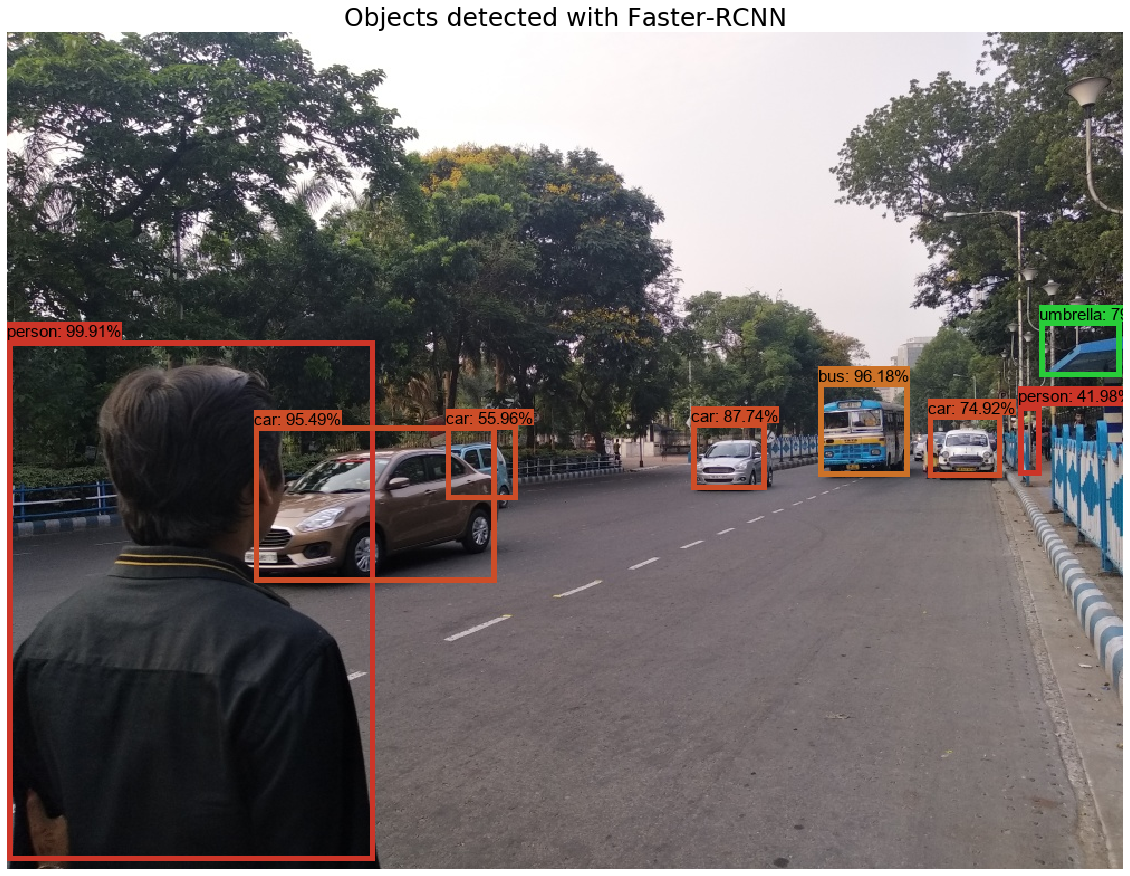

In [29]:
fig = plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Objects detected with Faster-RCNN', size=25)
plt.show()

### Object Detection with Mask-RCNN

4.1.1
(750, 1000, 3)


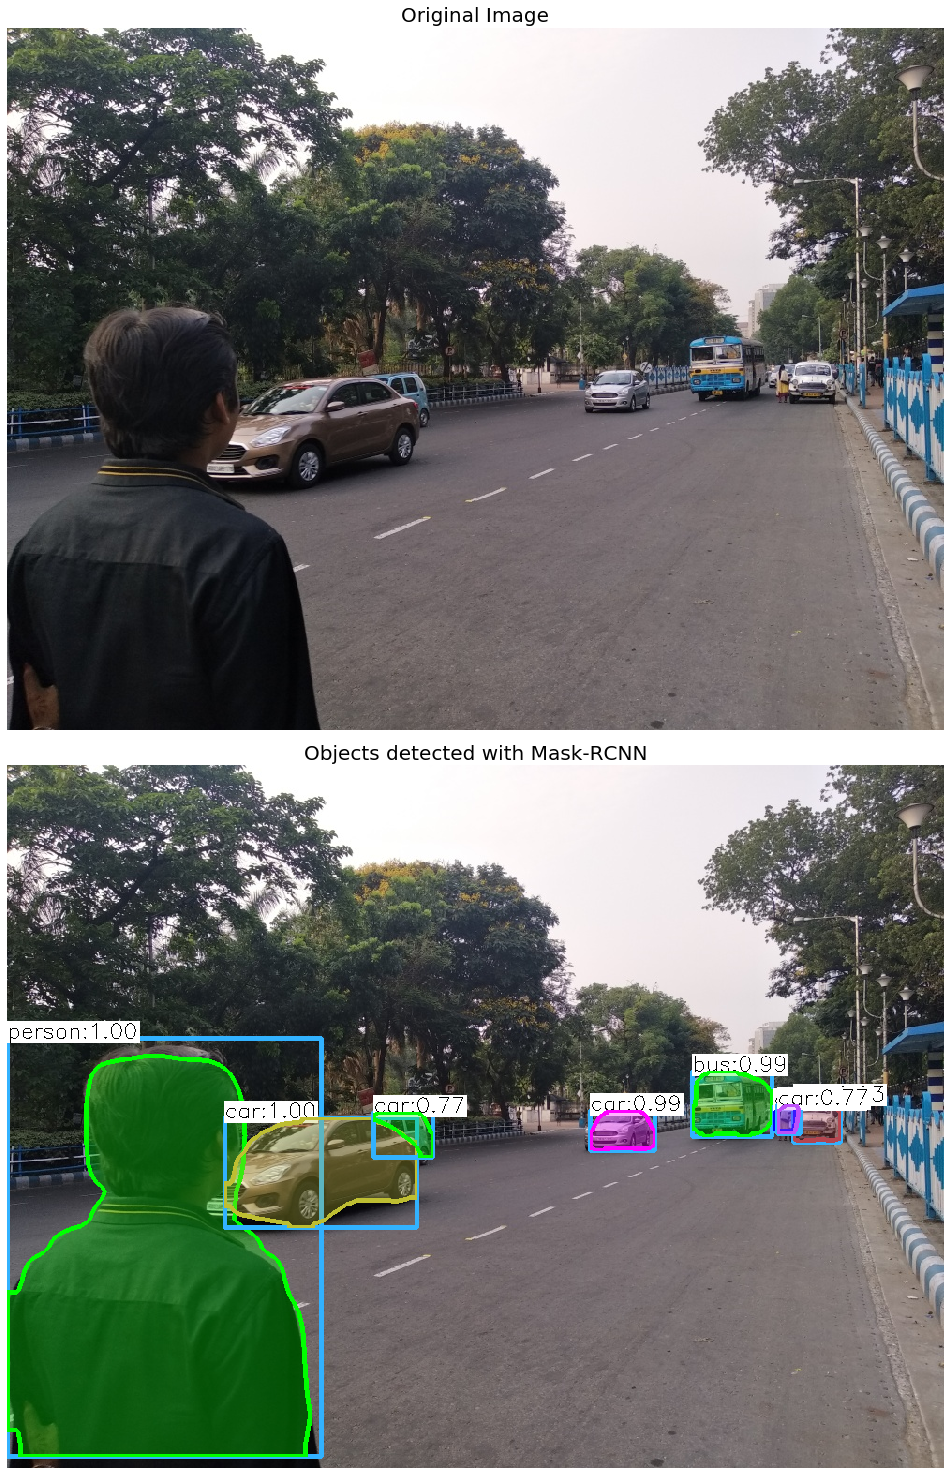

In [4]:
# http://download.tensorflow.org/models/object_detection/mask_rcnn_inception_v2_coco_2018_01_28.tar.gz
# https://github.com/opencv2/opencv2_extra/blob/master/testdata/dnn/download_models.py
# https://github.com/opencv2/opencv2_extra/tree/master/testdata/dnn
import cv2
import argparse
import numpy as np
import os.path
import sys
import random
import matplotlib.pylab as plt

print(cv2.__version__)

# Initialize the parameters
confThreshold = 0.5  # Confidence threshold
maskThreshold = 0.3  # Mask threshold

# Draw the predicted bounding box, colorize and show the mask on the image
def drawBox(img, classId, conf, left, top, right, bottom, classMask):
    # Draw a bounding box.
    cv2.rectangle(img, (left, top), (right, bottom), (255, 178, 50), 3)
    
    # Print a label of class.
    label = '%.2f' % conf
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)
    
    # Display the label at the top of the bounding box
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(img, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (255, 255, 255), cv2.FILLED)
    cv2.putText(img, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1)

    # Resize the mask, threshold, color and apply it on the image
    classMask = cv2.resize(classMask, (right - left + 1, bottom - top + 1))
    mask = (classMask > maskThreshold)
    roi = img[top:bottom+1, left:right+1][mask]

    # color = colors[classId%len(colors)]
    # Comment the above line and uncomment the two lines below to generate different instance colors
    colorIndex = random.randint(0, len(colors)-1)
    color = colors[colorIndex]

    img[top:bottom+1, left:right+1][mask] = ([0.3*color[0], 0.3*color[1], 0.3*color[2]] + 0.7 * roi).astype(np.uint8)

    # Draw the contours on the image
    mask = mask.astype(np.uint8)
    #im2, 
    contours, hierarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(img[top:bottom+1, left:right+1], contours, -1, color, 3, cv2.LINE_8, hierarchy, 100)

# For each img, extract the bounding box and mask for each detected object
def postprocess(boxes, masks):
    # Output size of masks is NxCxHxW where
    # N - number of detected boxes
    # C - number of classes (excluding background)
    # HxW - segmentation shape
    numClasses = masks.shape[1]
    numDetections = boxes.shape[2]

    imgH = img.shape[0]
    imgW = img.shape[1]

    for i in range(numDetections):
        box = boxes[0, 0, i]
        mask = masks[i]
        score = box[2]
        if score > confThreshold:
            classId = int(box[1])
            
            # Extract the bounding box
            left = int(imgW * box[3])
            top = int(imgH * box[4])
            right = int(imgW * box[5])
            bottom = int(imgH * box[6])
            
            left = max(0, min(left, imgW - 1))
            top = max(0, min(top, imgH - 1))
            right = max(0, min(right, imgW - 1))
            bottom = max(0, min(bottom, imgH - 1))
            
            # Extract the mask for the object
            classMask = mask[classId]

            # Draw bounding box, colorize and show the mask on the image
            drawBox(img, classId, score, left, top, right, bottom, classMask)


# Load names of classes
classesFile = "models/mask_rcnn_inception_v2_coco_2018_01_28/mscoco_labels.names";
classes = None
with open(classesFile, 'rt') as f:
   classes = f.read().rstrip('\n').split('\n')

# Give the textGraph and weight files for the model
textGraph = "models/mask_rcnn_inception_v2_coco_2018_01_28/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt";
modelWeights = "models/mask_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb";

# Load the network
net = cv2.dnn.readNetFromTensorflow(modelWeights, textGraph);
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# Load the classes
colorsFile = "models/mask_rcnn_inception_v2_coco_2018_01_28/colors.txt";
with open(colorsFile, 'rt') as f:
    colorsStr = f.read().rstrip('\n').split('\n')
colors = [] #[0,0,0]
for i in range(len(colorsStr)):
    rgb = colorsStr[i].split(' ')
    color = np.array([float(rgb[0]), float(rgb[1]), float(rgb[2])])
    colors.append(color)

img = cv2.imread('images/road.png')
    
print(img.shape)

orig = np.copy(img)
#cv2.imwrite('Mask-RCNN/input/img_' + str(i).zfill(4) + '.jpg', orig)

# Create a 4D blob from a img.
blob = cv2.dnn.blobFromImage(img, swapRB=True, crop=False)

# Set the input to the network
net.setInput(blob)

# Run the forward pass to get output from the output layers
boxes, masks = net.forward(['detection_out_final', 'detection_masks'])

# Extract the bounding box and mask for each of the detected objects
postprocess(boxes, masks)

# Put efficiency information.
t, _ = net.getPerfProfile()
#label = 'Mask-RCNN on 2.5 GHz Intel Core i7 CPU, Inference time for a img : %0.0f ms' % abs(t * 1000.0 / cv2.getTickFrequency())
#cv2.putText(img, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 
plt.subplot(211), plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Original Image', size=20)
plt.subplot(212), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Objects detected with Mask-RCNN', size=20)
plt.show()

### Text Detection in images with Tesseract

In [24]:
# https://stackoverflow.com/questions/44619077/pytesseract-ocr-multiple-config-options
# https://codeload.github.com/ZER-0-NE/EAST-Detector-for-text-detection-using-OpenCV/zip/master
# import the necessary packages
from imutils.object_detection import non_max_suppression
import numpy as np
import pytesseract
import cv2

min_confidence = 0.5

def decode_predictions(scores, geometry):
    # grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and corresponding
    # confidence scores
    (num_rows, num_cols) = scores.shape[2:4]
    rects = []
    confidences = []
 
    # loop over the number of rows
    for y in range(0, num_rows):
        # extract the scores (probabilities), followed by the
        # geometrical data used to derive potential bounding box
        # coordinates that surround text
        scores_data = scores[0, 0, y]
        x_data0 = geometry[0, 0, y]
        x_data1 = geometry[0, 1, y]
        x_data2 = geometry[0, 2, y]
        x_data3 = geometry[0, 3, y]
        angles_data = geometry[0, 4, y]
 
        # loop over the number of columns
        for x in range(0, num_cols):
            # if our score does not have sufficient probability,
            # ignore it
            if scores_data[x] < min_confidence:
                continue
 
            # compute the offset factor as our resulting feature
            # maps will be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)
 
            # extract the rotation angle for the prediction and
            # then compute the sin and cosine
            angle = angles_data[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
 
            # use the geometry volume to derive the width and height
            # of the bounding box
            h = x_data0[x] + x_data2[x]
            w = x_data1[x] + x_data3[x]
 
            # compute both the starting and ending (x, y)-coordinates
            # for the text prediction bounding box
            end_x = int(offsetX + (cos * x_data1[x]) + (sin * x_data2[x]))
            end_y = int(offsetY - (sin * x_data1[x]) + (cos * x_data2[x]))
            start_x = int(end_x - w)
            start_y = int(end_y - h)
 
            # add the bounding box coordinates and probability score
            # to our respective lists
            rects.append((start_x, start_y, end_x, end_y))
            confidences.append(scores_data[x])
 
    # return a tuple of the bounding boxes and associated confidences
    return (rects, confidences)

# load the input image and grab the image dimensions
im = 'images/book_cover.png'
image = cv2.imread(im)
orig = image.copy()
(origH, origW) = image.shape[:2]
 
# set the new width and height and then determine the ratio in change
# for both the width and height
width = height = 32*10 #320
(w, h) = (width, height)
rW = origW / float(w)
rH = origH / float(h)
 
# resize the image and grab the new image dimensions
image = cv2.resize(image, (w, h))
(H, W) = image.shape[:2]

# define the two output layer names for the EAST detector model that
# we are interested in -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = [
    "feature_fusion/Conv_7/Sigmoid",
    "feature_fusion/concat_3"]
 
# load the pre-trained EAST text detector
print("loading EAST text detector...")
net = cv2.dnn.readNet('models/east/frozen_east_text_detection.pb')

# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets
b, g, r = np.mean(image[...,0]), np.mean(image[...,1]), np.mean(image[...,2])
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (b, g, r), swapRB=True, crop=False)
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
 
# decode the predictions, then  apply non-maxima suppression to
# suppress weak, overlapping bounding boxes
(rects, confidences) = decode_predictions(scores, geometry)
boxes = non_max_suppression(np.array(rects), probs=confidences)

padding = 0.001 #0.01 #0.5
# initialize the list of results
results = []
 
# loop over the bounding boxes
for (start_x, start_y, end_x, end_y) in boxes:
    # scale the bounding box coordinates based on the respective ratios
    start_x = int(start_x * rW)
    start_y = int(start_y * rH)
    end_x = int(end_x * rW)
    end_y = int(end_y * rH)

    # in order to obtain a better OCR of the text we can potentially
    # apply a bit of padding surrounding the bounding box -- here we
    # are computing the deltas in both the x and y directions
    dX = int((end_x - start_x) * padding)
    dY = int((end_y - start_y) * padding)

    # apply padding to each side of the bounding box, respectively
    start_x = max(0, start_x - dX*2)
    start_y = max(0, start_y - dY*2)
    end_x = min(origW, end_x + (dX * 2))
    end_y = min(origH, end_y + (dY * 2))

    # extract the actual padded ROI
    roi = orig[start_y:end_y, start_x:end_x]

    # in order to apply Tesseract v4 to OCR text we must supply
    # (1) a language, (2) an OEM flag of 4, indicating that the we
    # wish to use the LSTM neural net model for OCR, and finally
    # (3) an OEM value, in this case, 7 which implies that we are
    # treating the ROI as a single line of text
    config = ("-l eng --oem 1 --psm 11")
    text = pytesseract.image_to_string(roi, config=config)
    #print(text)

    # add the bounding box coordinates and OCR'd text to the list
    # of results
    results.append(((start_x, start_y, end_x, end_y), text))

    # sort the results bounding box coordinates from top to bottom
    results = sorted(results, key=lambda r:r[0][1])
 
print(len(results))
# loop over the results
output = orig.copy()
i = 1
for ((start_x, start_y, end_x, end_y), text) in results:
    # display the text OCR'd by Tesseract
    #print("OCR TEXT")
    #print("========")
    print(text)

    # strip out non-ASCII text so we can draw the text on the image
    # using OpenCV, then draw the text and a bounding box surrounding
    # the text region of the input image
    text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
    cv2.rectangle(output, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)
    cv2.putText(output, text, (start_x, start_y - 20), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

    # show the output image
    i += 1
cv2.imwrite("images/text_" + im.split('/')[-1], output)

loading EAST text detector...
8
Hands-On
Processing
Image
with
Python
Packt
Sandipan
Dey


True

![](images\text_book_cover.png)

### Barcode detection

In [43]:
#! pip install python-Levenshtein
#! pip install python-barcode
#! pip install qrcode
#! pip install pyzbar
from PIL import ImageFont, ImageDraw, Image  
from pyzbar import pyzbar
import cv2
import numpy as np
import barcode
from barcode.writer import ImageWriter

bar1 = barcode.get('ean13', str('123456789012'), writer=ImageWriter())
#bar1 = barcode.codex.Code39( "Sandipan Dey - Image Processing - Packt",  writer=ImageWriter(),  add_checksum=False)
bar1.save('images/bar1')

import qrcode
qr = qrcode.QRCode(
    version=1,
    error_correction=qrcode.constants.ERROR_CORRECT_L,
    box_size=10,
    border=4,
)
qr.add_data(u'বই: Image Processing CookBook (Packt)')
qr.make(fit=True)
bar2 = qr.make_image(fill_color="black", back_color="white")
bar2.save('images/bar2.png')

im = Image.open('images/book_cover.png')
bar1 = Image.open('images/bar1.png')
bar2 = Image.open('images/bar2.png')
im.paste(bar1.resize((262,140)).rotate(10), (750,10,1012,150))
im.paste(bar2.resize((100,100)).rotate(-10), (500,1060,600,1160))
im.save('images/book_cover_barcode.png')

In [46]:
# load the input image
image = cv2.imread('images/book_cover_barcode.png')
# find the barcodes in the image and decode each of the barcodes
barcodes = pyzbar.decode(image)
print(len(barcodes))
# loop over the detected barcodes
for barcode in barcodes:
    # extract the bounding box location of the barcode and draw the
    # bounding box surrounding the barcode on the image
    (x, y, w, h) = barcode.rect
    
    # the barcode data is a bytes object so if we want to draw it on
    # our output image we need to convert it to a string first
    barcodeData = barcode.data.decode("utf-8")
    barcodeType = barcode.type
    
    #if barcodeType == 'EAN13':
    #    barcodeData = bytes.fromhex('0'+ hex(int(barcodeData))[2:]).decode("utf-8")
 
    # draw the barcode data and barcode type on the image
    text = u"{} ({})".format(barcodeData, barcodeType)
    
    # Convert the image to RGB (OpenCV uses BGR)  
    cv2_im_rgb = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)  
    pil_im = Image.fromarray(cv2_im_rgb)  
    draw = ImageDraw.Draw(pil_im)  
    font = ImageFont.truetype("images/kalpurush.ttf", size=30, layout_engine=ImageFont.LAYOUT_RAQM)  
    draw.line(barcode.polygon,width=15)
    draw.polygon(barcode.polygon, outline='#0000ff')
    draw.rectangle(((x, y), (x + w, y + h)), outline='#ff0000', width=10)
    draw.text((x - 100, y - 30), text, font=font, fill=(0,255,0,255))  
    image = cv2.cvtColor(np.array(pil_im), cv2.COLOR_RGB2BGR)  
    
    # print the barcode type and data to the terminal
    print("[INFO] Found {} barcode: {}".format(barcodeType, barcodeData))
    
cv2.imwrite('images/book_cover_barcode_detected.png', image)    

2
[INFO] Found QRCODE barcode: বই: Image Processing CookBook (Packt)
[INFO] Found EAN13 barcode: 1234567890128


True

![](images/book_cover_barcode_detected.png)